In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn import preprocessing, svm
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

## Data loading

In [2]:


dfImages = pd.read_csv('../data/IAPS.csv',
                       sep=';',
                       usecols=['IAPS', 'ValenceMean', 'ArousalMean']
                      )



dfSounds = pd.read_csv('../data/IADS2.csv', sep=';', usecols=['Number', 'ValenceMean', 'ArousalMean'])


studyDatafiles = glob.glob('../data/procedura/*.txt')

li = []

for filename in studyDatafiles:
    df = pd.read_csv(filename, sep='\t', header=None, names=['ID', 'nn', 'Condition', 'SpecificCondition', 'Number', 'IAPS', 'Widget', 'Response', 'Delay', 'ApperanceTimestamp'])
    li.append(df)
                         
dfStudy = pd.concat(li, axis=0, ignore_index=True)

dfStudy = dfStudy[dfStudy.Condition != 'con']
dfStudy = dfStudy[dfStudy.Widget != 'emoscale1']
                                     


## Preprocessing

In [3]:


dfStudy['Number'] = pd.to_numeric(dfStudy['Number'])



def convertResponseStringIntoColumns(string):
    string = string[1:-1]
    array = (string.split(','))
    array[0] = (float(array[0]) * 4) + 5
    array[1] = (float(array[1][1:]) * 4) + 5
    return array

def findExpectedImageReaction(iaps):
    valence = dfImages[dfImages.IAPS == str(iaps)].ValenceMean.tolist()
    arousal = dfImages[dfImages.IAPS == str(iaps)].ArousalMean.tolist()
    
    return [sum(valence)/len(valence), sum(arousal)/len(arousal)] if valence else [np.nan, np.nan]

def findExpectedSoundReaction(number):
    valence = dfSounds[dfSounds.Number == number].ValenceMean.tolist()
    arousal = dfSounds[dfSounds.Number == number].ArousalMean.tolist()
    
    return [sum(valence)/len(valence), sum(arousal)/len(arousal)] if valence else [np.nan, np.nan]

def applySpecificCondition(condition, i):
    if (condition[1] == '-' and i == 0) or (condition[3] == '-' and i == 1):
        return -1
    else:
        return 1

def labelReaction(valence):
    return 1 if valence < 5 else -1

    
def getValence(array):
    return array[0]

def getArousal(array):
    return array[1]
    
dfStudy['ActualReaction'] = dfStudy.Response.apply(func = convertResponseStringIntoColumns)

dfStudy['ExpectedImageReaction'] = dfStudy.IAPS.apply(findExpectedImageReaction)
dfStudy['ExpectedSoundReaction'] = dfStudy.Number.apply(findExpectedSoundReaction)
       
dfStudy['ImageCondition'] = dfStudy.SpecificCondition.apply(applySpecificCondition, i = 0)
dfStudy['SoundCondition'] = dfStudy.SpecificCondition.apply(applySpecificCondition, i = 1)

dfStudy['ImageValence'] = dfStudy.ExpectedImageReaction.apply(getValence)
dfStudy['ImageArousal'] = dfStudy.ExpectedImageReaction.apply(getArousal)
dfStudy['SoundValence'] = dfStudy.ExpectedSoundReaction.apply(getValence)
dfStudy['SoundArousal'] = dfStudy.ExpectedSoundReaction.apply(getArousal)
dfStudy['ActualValence'] = dfStudy.ActualReaction.apply(getValence)
dfStudy['ActualArousal'] = dfStudy.ActualReaction.apply(getArousal)
dfStudy['Label'] = dfStudy.ActualValence.apply(labelReaction)

df = dfStudy[['ImageCondition',
              'ImageValence',
              'ImageArousal',
              'SoundCondition',
              'SoundValence',
              'SoundArousal',
              'ActualValence',
              'ActualArousal',
              'Label'
             ]]
df = df.dropna()
df.head()


,ImageCondition,ImageValence,ImageArousal,SoundCondition,SoundValence,SoundArousal,ActualValence,ActualArousal,Label
6,1,6.44,7.07,-1,2.22,7.52,5.000000,1.451538,-1
7,-1,2.26,6.55,1,6.77,6.32,1.443176,5.000000,1
8,1,5.89,6.21,-1,1.63,7.79,2.311633,2.264209,1
9,1,6.83,5.40,-1,2.89,6.91,2.390496,7.665098,1
10,-1,2.95,5.91,1,7.65,7.12,1.604028,5.000000,1


## Linear Regression Model



In [4]:


x = df[['ImageCondition', 'ImageValence', 'ImageArousal',
        'SoundCondition', 'SoundValence', 'SoundArousal']]
    
y = df[['Label']]

clf = LinearRegression(n_jobs=-1)
X = np.array(x)
Y =  np.array(y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.9)
clf.fit(X_train, Y_train)
print('Image Condition ImageValence ImageArousal SoundCondition SoundValence SoundArousal ||Label')
print(clf.score(X_test, Y_test))
print(clf.coef_)

X = np.array(df[['ImageValence',
        'SoundValence']])
X = preprocessing.scale(X)
Y = np.array(df['ActualValence'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
clf.fit(X_train, Y_train)

print('ImageValence SoundValence || ActualValence')
print(clf.score(X_test, Y_test))
print(clf.coef_)



X = np.array(df[['ImageArousal',
        'SoundArousal']])
Y = np.array(df['ActualArousal'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
clf.fit(X_train, Y_train)

print('ImageArousal SoundArousal || ActualArousal')
print(clf.score(X_test, Y_test))
print(clf.coef_)

      






Image Condition ImageValence ImageArousal SoundCondition SoundValence SoundArousal ||Label
0.12224942255697123
[[-2.74548687  1.10404543 -0.01170916  2.74548687 -1.29034833  0.09299211]]
ImageValence SoundValence || ActualValence
0.16845792810795834
[1.58200456 0.99494721]
ImageArousal SoundArousal || ActualArousal
0.004928996195625812
[0.28439139 0.27872412]


## SVR

In [5]:


clf = svm.SVR(kernel='linear', gamma='auto')

X = np.array(df[['ImageValence',
        'SoundValence']])
Y = np.array(df['ActualValence'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
clf.fit(X_train, Y_train)

print('ImageValence SoundValence || ActualValence')
print(clf.score(X_test, Y_test))
print(clf.coef_)

      
X = np.array(df[['ImageArousal',
        'SoundArousal']])
Y = np.array(df['ActualArousal'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
clf.fit(X_train, Y_train)

print('ImageArousal SoundArousal || ActualArousal')
print(clf.score(X_test, Y_test))
print(clf.coef_)





ImageValence SoundValence || ActualValence
0.184755468547377
[[0.68794857 0.42314164]]
ImageArousal SoundArousal || ActualArousal
0.021060723360483924
[[0.23595725 0.33194579]]


In [6]:
## OLS

                            OLS Regression Results                            
Dep. Variable:          ActualValence   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     329.5
Date:                Tue, 11 Jun 2019   Prob (F-statistic):          7.71e-129
Time:                        20:42:12   Log-Likelihood:                -5325.9
No. Observations:                2715   AIC:                         1.066e+04
Df Residuals:                    2712   BIC:                         1.068e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.8397      0.282     -2.981   

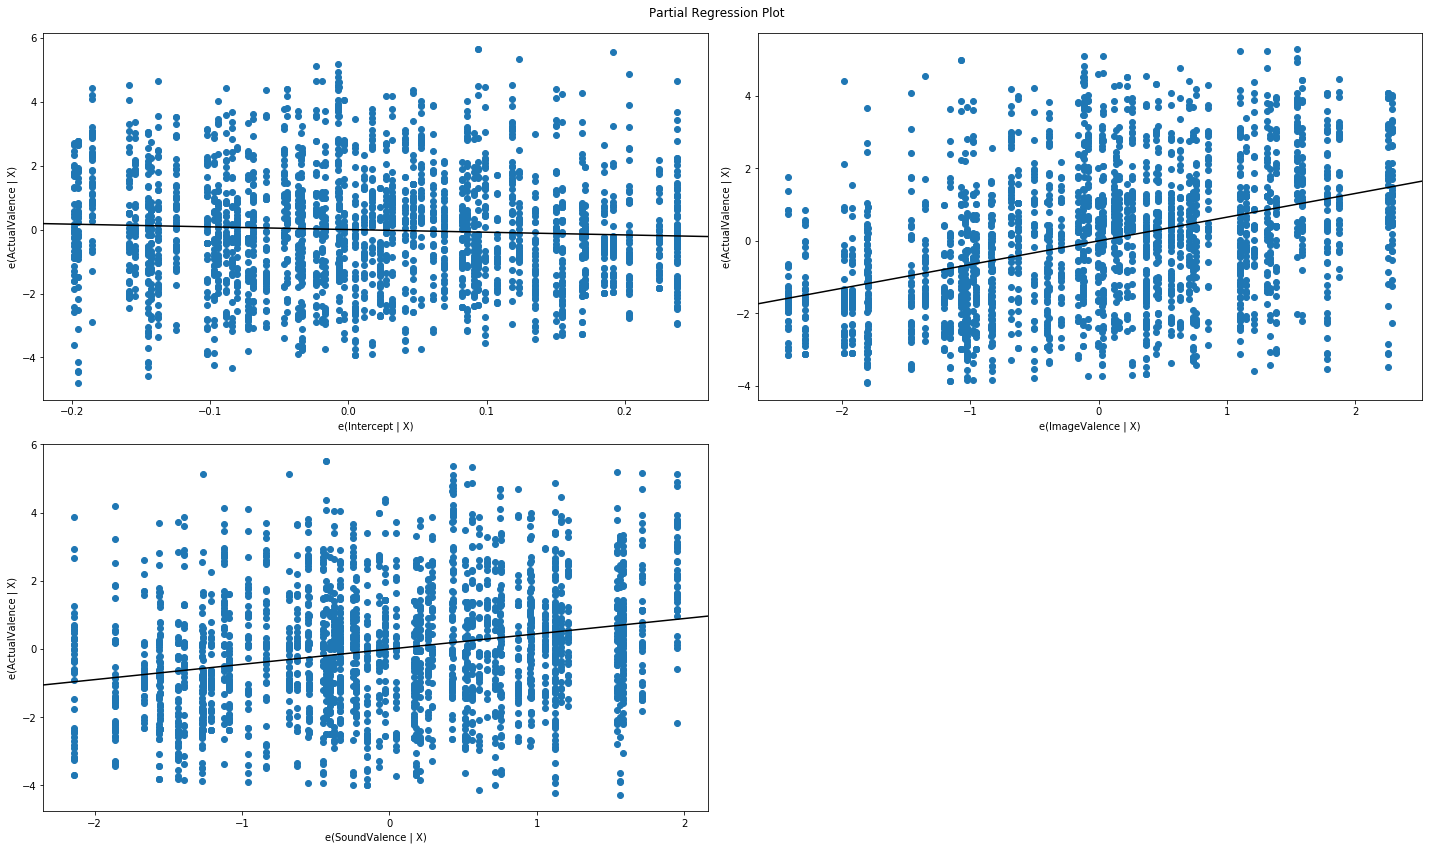

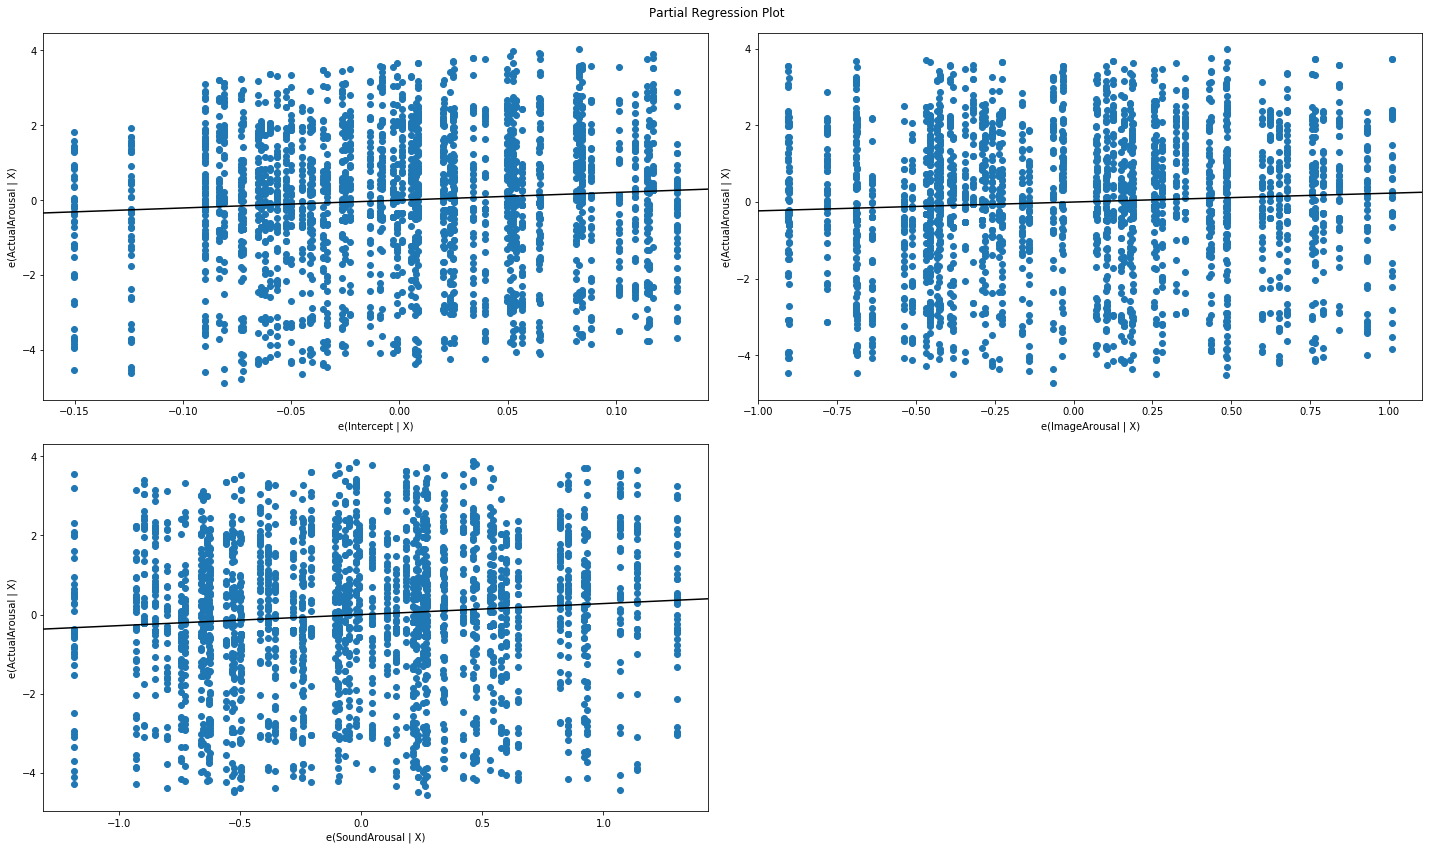

In [7]:
olsModel = ols("""ActualValence ~ ImageValence + SoundValence""", data=df).fit()

fig = plt.figure(figsize=(20,12))
fig = sm.graphics.plot_partregress_grid(olsModel, fig=fig)

print(olsModel.summary())


olsModel = ols("""ActualArousal ~ ImageArousal + SoundArousal""", data=df).fit()

fig = plt.figure(figsize=(20,12))
fig = sm.graphics.plot_partregress_grid(olsModel, fig=fig)

print(olsModel.summary())


## Decision Tree

In [8]:


clf = DecisionTreeRegressor()

X = np.array(df[['ImageValence',
        'SoundValence']])
Y = np.array(df['ActualValence'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
clf.fit(X_train, Y_train)

print('ImageValence SoundValence || ActualValence')
print(clf.score(X_test, Y_test))


      
X = np.array(df[['ImageArousal',
        'SoundArousal']])
Y = np.array(df['ActualArousal'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
clf.fit(X_train, Y_train)

print('ImageArousal SoundArousal || ActualArousal')
print(clf.score(X_test, Y_test))






ImageValence SoundValence || ActualValence
0.26178886689969816
ImageArousal SoundArousal || ActualArousal
0.03183895696331018
